    # **ДЗ №6 STEM. Алексеев Виталий.**

## **0 Импорт библиотек**

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy
import seaborn as sns

plt.style.use("ggplot")
np.random.seed(42)

In [240]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1ouzoz-W2y5LbgmZjguVwBsgje93UaACc", delimiter=";")

In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419 entries, 0 to 418
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   JD      419 non-null    float64
 1   mag     419 non-null    float64
dtypes: float64(2)
memory usage: 6.7 KB


## **1 Чистка данных**

In [242]:
rolling_median = df['mag'].rolling(11).median()
residuals = df['mag'] - rolling_median
mask = np.abs(residuals) < 3 * residuals.std()

df_clipped = df[mask]
excluded = df[~mask]
print(f"Число до: {len(df)}, после - {len(df_clipped)}")


time_base = df['JD'].max() - df['JD'].min()
dt_median = np.median(np.diff(np.sort(df['JD'])))
print(f"Временной базис: {time_base:.1f} дней, медианный интервал: {dt_median:.6f}")

excluded.head(10)

Число до: 419, после - 409
Временной базис: 3127.3 дней, медианный интервал: 0.007270


,JD,mag
0,2.453470e+06,16.09
1,2.453470e+06,16.07
2,2.453470e+06,16.08
3,2.453470e+06,16.08
4,2.453481e+06,16.09
5,2.453481e+06,16.10
6,2.453481e+06,16.07
7,2.453481e+06,16.14
8,2.453727e+06,16.12
9,2.453727e+06,16.06


Согласно правилу трех сигм, в интервале $(\mu-3\sigma;\mu+3\sigma)$ содержится примерно $95\%$ значений, поэтому использование такого порога позволяет исключить сильные выбросы, явно не подходящие под рассмотрение.

## **2 Периодограмма Ломба–Скаргла: сетка частот и значимость**

1. Частота: 0.674140, период: 1.483371, мощность: 0.693675
2. Частота: 0.328573, период: 3.043465, мощность: 0.597875
3. Частота: 1.676922, период: 0.596331, мощность: 0.551093


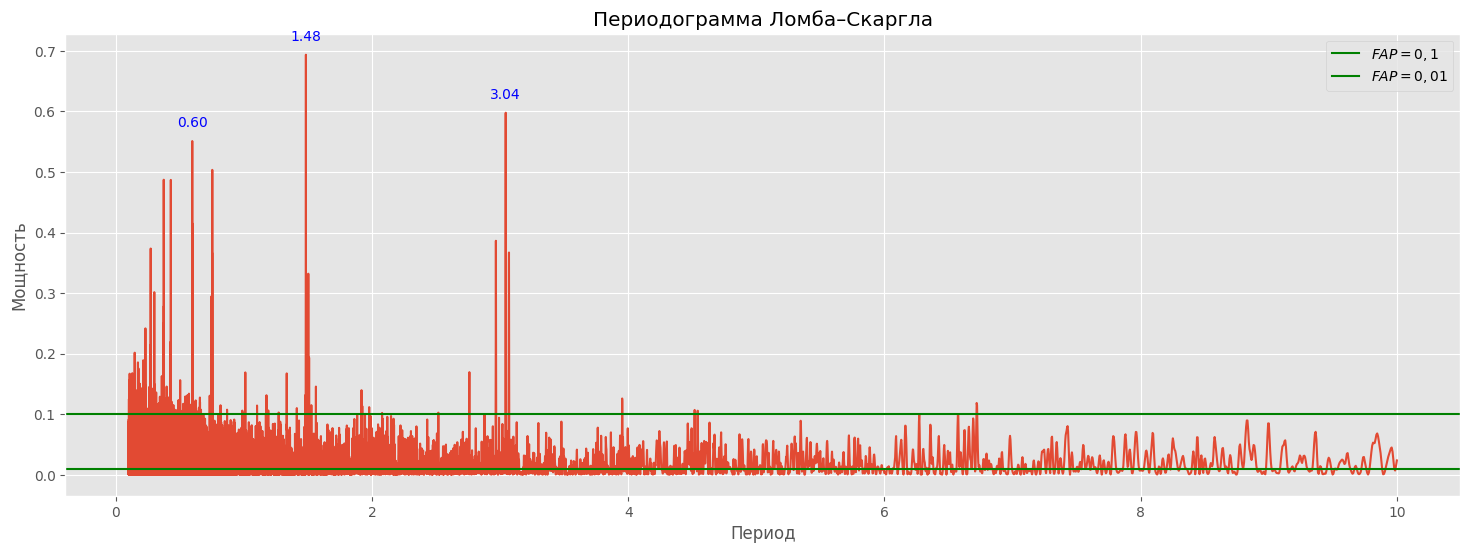

In [243]:
from scipy.signal import find_peaks

f_min = 0.1
f_max = 10

frequency, powers = astropy.timeseries.LombScargle(
    df_clipped["JD"], df_clipped["mag"]
).autopower(minimum_frequency=f_min, maximum_frequency=f_max)
periods = 1 / frequency

sorted_idx = np.argsort(periods)
periods_sorted = periods[sorted_idx]
powers_sorted = powers[sorted_idx]

peaks, _ = find_peaks(powers_sorted)

top_peaks_idx = np.argsort(powers_sorted[peaks])[-3:]
top_peaks = peaks[top_peaks_idx]


plt.figure(figsize=(18, 6))
plt.plot(periods, powers)
for j, i in enumerate(top_peaks[::-1]):
  print(f"{j + 1}. Частота: {1 / periods_sorted[i]:.6f}, период: {periods_sorted[i]:.6f}, мощность: {powers_sorted[i]:.6f}")
  plt.annotate(f"{periods_sorted[i]:.2f}", (periods_sorted[i], powers_sorted[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', color="b")
plt.axhline(0.01, color="g", label="$FAP=0,1$")
plt.axhline(0.1, color="g", label="$FAP=0,01$")

plt.legend()
plt.title("Периодограмма Ломба–Скаргла")
plt.xlabel("Период")
plt.ylabel("Мощность")
plt.show()

Шаг сетки выбрали $0,1$, поскольку этого достаточно, чтобы выбрать наиболее значимый период, и в то же время, не перенасыщает график $FAP\ge 0.1$ периодами, поскольку вблизи нуля создается достаточно большое кол-во ложных периодов.

## **3 Фазировка и параметры формы кривой блеска**

In [244]:
best_period = periods[top_3[0]]
df_clipped.loc[:, "phase"] = ((df_clipped["JD"] - df_clipped['JD'].min()) % best_period) / best_period
df_clipped = df_clipped.sort_values(by='phase')

/tmp/ipython-input-3688496931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clipped.loc[:, "phase"] = ((df_clipped["JD"] - df_clipped['JD'].min()) % best_period) / best_period


Здесь мы выбрали максимум, чтобы работать с положительными фазами, т.к. очевидно, с ними работать нагляднее, в остальном никаких отличий с максимумом нет.

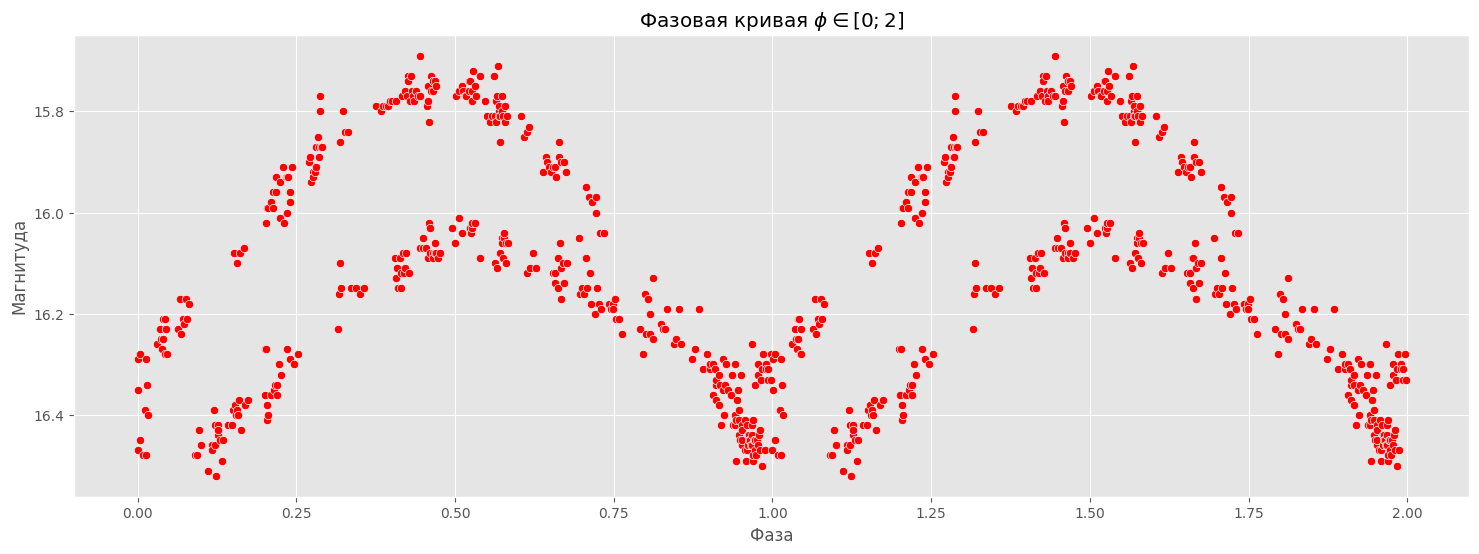

In [245]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x=df_clipped["phase"], y=df_clipped["mag"], color="r")
sns.scatterplot(x=df_clipped["phase"] + 1, y=df_clipped["mag"], color="r")
plt.gca().invert_yaxis()
plt.title(r"Фазовая кривая $\phi \in [0;2]$")
plt.xlabel("Фаза")
plt.ylabel("Магнитуда")
plt.show()

По графику примерно оценим амплитуду:
$$A=m_{\max}-{\min}\approx 16,3-15, 75=0,55$$
Указанные значения соответсвуют фазам $\approx 0,75$ и $\approx0.125$ соответственно. Найдем ассиметрию как отношение длин промежутков возрастания к длине всей фазы, т.е. 1:
$$\frac{0,5-0,0}{1}=0,5$$
У данного объекта очевидно прослеживаются две разные фазовые кривые, чего просто не может быть (!), поэтому напрашивается вывод о том, что это не одна звезда, а система из **двух** объектов с разной светимостью.

## **4 Проверка на затменную систему (период-пополам)**

In [246]:
best_period = periods[top_3[0]] * 2
df_clipped.loc[:, "phase"] = ((df_clipped["JD"] - df_clipped['JD'].min()) % best_period) / best_period
df_clipped = df_clipped.sort_values(by='phase')

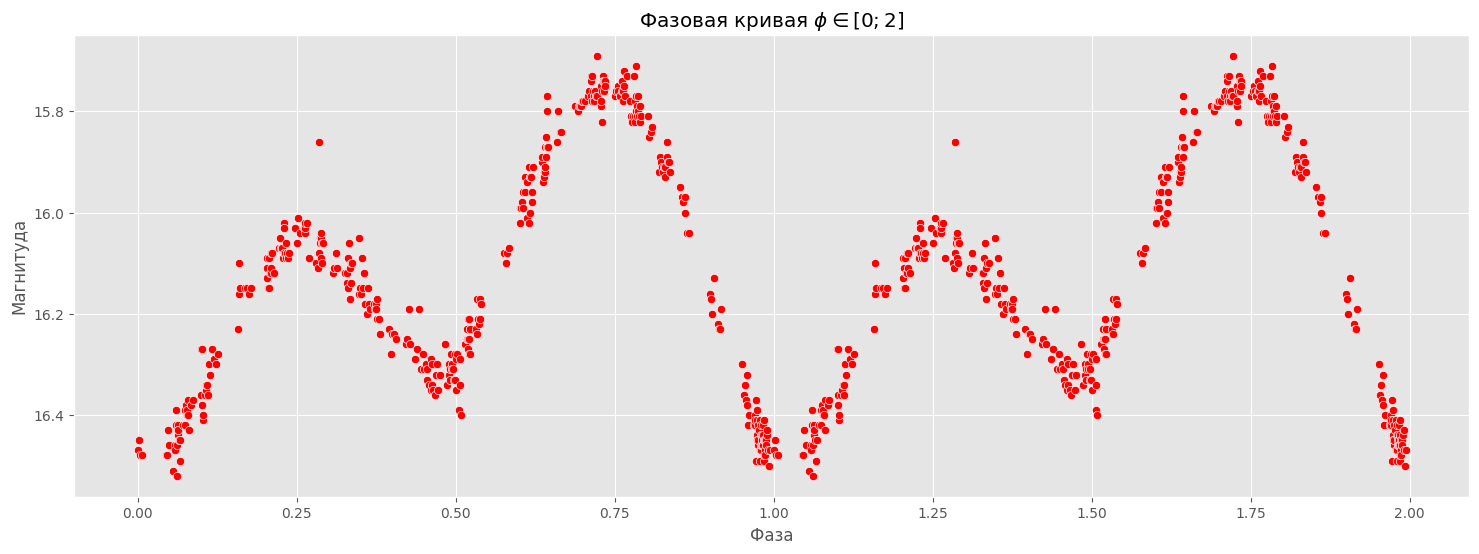

In [247]:
plt.figure(figsize=(18, 6))
sns.scatterplot(x=df_clipped["phase"], y=df_clipped["mag"], color="r")
sns.scatterplot(x=df_clipped["phase"] + 1, y=df_clipped["mag"], color="r")
plt.gca().invert_yaxis()
plt.title(r"Фазовая кривая $\phi \in [0;2]$")
plt.xlabel("Фаза")
plt.ylabel("Магнитуда")
plt.show()

In [248]:
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.stats import pearsonr
from statsmodels.nonparametric.smoothers_lowess import lowess


def calculate_metrics(phase, mag):
    bin_edges = np.linspace(0, 1, 50 + 1)

    dispersions = []
    for i in range(50):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i+1])
        if mask.sum() > 0:
            disp = np.var(mag[mask])
            dispersions.append(disp)
    mean_dispersion = np.mean(dispersions)

    lowess_result = lowess(mag, phase, frac=0.3)
    phase_smooth = lowess_result[:, 0]
    mag_smooth = lowess_result[:, 1]

    interp_smooth = interp1d(phase_smooth, mag_smooth, kind='linear',
                             bounds_error=False, fill_value='extrapolate')
    mag_fit = interp_smooth(phase)
    chi2 = np.mean((mag - mag_fit) ** 2)

    phase_grid = np.linspace(0, 0.5, 100)

    mask1 = phase <= 0.5
    mag1_interp = interp1d(
        phase[mask1],
        mag[mask1],
        fill_value='extrapolate')(phase_grid)
    mask2 = phase >= 0.5
    mag2_interp = interp1d(
        phase[mask2] - 0.5,
        mag[mask2],
        fill_value='extrapolate')(phase_grid)
    corr = np.corrcoef(mag1_interp, mag2_interp)[0, 1]

    return {
        'Mean Dispersion': mean_dispersion,
        'Chi2': chi2,
        'Correlation': corr
    }

In [249]:
best_period = periods[top_3[0]]
df_clipped.loc[:, "phase"] = ((df_clipped["JD"] - df_clipped['JD'].min()) % best_period) / best_period
df_clipped = df_clipped.sort_values(by='phase')
p_metrics = calculate_metrics(df_clipped["phase"], df_clipped["mag"])

best_period = periods[top_3[0]] * 2
df_clipped.loc[:, "phase"] = ((df_clipped["JD"] - df_clipped['JD'].min()) % best_period) / best_period
df_clipped = df_clipped.sort_values(by='phase')
p2_metrics = calculate_metrics(df_clipped["phase"], df_clipped["mag"])

metrics = pd.DataFrame({"P": p_metrics, "2P": p2_metrics})
metrics

,P,2P
Mean Dispersion,0.008947,0.000862
Chi2,0.016539,0.002179
Correlation,-0.654454,0.752741


Исходя из приведенной таблицы, а также самого графика, очевидно, что выбор периода $2\hat{P}$ более целесообразен, основная причина - дисперсия стала на порядок (!) меньше, кроме того, корреляция изменила свой знак и возросла, а $\chi^2$ изменился не более чем на $\approx0,5$, что не особо критично в контексте изменившейся медианы.

## **5 Гармонический Фурье фит и диагностические индексы**

In [250]:
from scipy.optimize import curve_fit

def fourier_model(phi, *params):
    m0 = params[0]
    N = (len(params) - 1) // 2
    result = np.full_like(phi, m0, dtype=float)
    for k in range(1, N+1):
        ak = params[2*k - 1]
        bk = params[2*k]
        result += ak * np.cos(2 * np.pi * k * phi) + bk * np.sin(2 * np.pi * k * phi)
    return result

def fit_fourier(phi, mag, err, N=4):
    params_init = [np.median(mag)] + [0]*(2*N)
    popt, _ = curve_fit(lambda phi, *params: fourier_model(phi, *params),
                        phi, mag, p0=params_init, sigma=err, absolute_sigma=True)
    return popt

N = 4
popt = fit_fourier(
    df_clipped["phase"].values, df_clipped["mag"].values,
    df_clipped.get("err", np.full_like(df_clipped["mag"], 0.05)),
    N=N
)
m0 = popt[0]
coeff_table = []
for k in range(1, N+1):
    ak = popt[2*k - 1]
    bk = popt[2*k]
    coeff_table.append({"k": k, "a_k": ak, "b_k": bk})
coeff_df = pd.DataFrame(coeff_table)
coeff_df.set_index("k", inplace=True)
display(coeff_df)

a1, b1 = popt[1], popt[2]
a2, b2 = popt[3], popt[4]
print(f"A1 = {np.sqrt(a1**2 + b1**2)}")
print(f"A2 = {np.sqrt(a2**2 + b2**2)}")
print(f"R21 = {np.sqrt(a1**2 + b1**2) / np.sqrt(a2**2 + b2**2)}")
print(f"phi21 = {np.angle(a2 + 1j * b2) - 2 * np.angle(a1 + 1j * b1)}")

,a_k,b_k
k,,
1,0.083647,0.160971
2,0.238270,-0.008239
3,0.005594,0.012302
4,0.017613,-0.000458


A1 = 0.1814070944751013
A2 = 0.23841190424230557
R21 = 0.7608978043761252
phi21 = -2.217679836365092


$R_{21}$ отражает степень негармоничности или асимметрии кривой:
  - Малое $R_{21}$ (≈0–0.2): почти синусоидальные кривые (ротаторы, регулярные пульсаторы).

  - Большое $R_{21}$ (>0.5): асимметрия, затмения, RR-Лиры с резким подъёмом.

$\varphi_{21}$ показывает относительную фазу между 1-й и 2-й гармоникой:
  - $\varphi_{21}$ близко к 0 или $\pi$: симметричная форма (классические цефеиды, переменные типа DSCT).

   - $\varphi_{21}$ в окрестности $\frac{\pi}{2}$  : асимметрия, необычная форма затмения, необычные процессы.

## **6 Бутстрэп-оценка надёжности периода**

In [251]:
period_min = 1 / f_max
period_max = 1 / f_min

period_grid = np.linspace(period_min, period_max, 1000)
freq_grid = 1 / period_grid

best_periods = []

for b in range(200):
    mixed_mag = np.random.permutation(df_clipped["mag"])
    powers = astropy.timeseries.LombScargle(df_clipped["JD"], mixed_mag).power(period_grid)
    best_idx = np.argmax(powers)
    best_periods.append(period_grid[best_idx])

best_periods = np.array(best_periods)

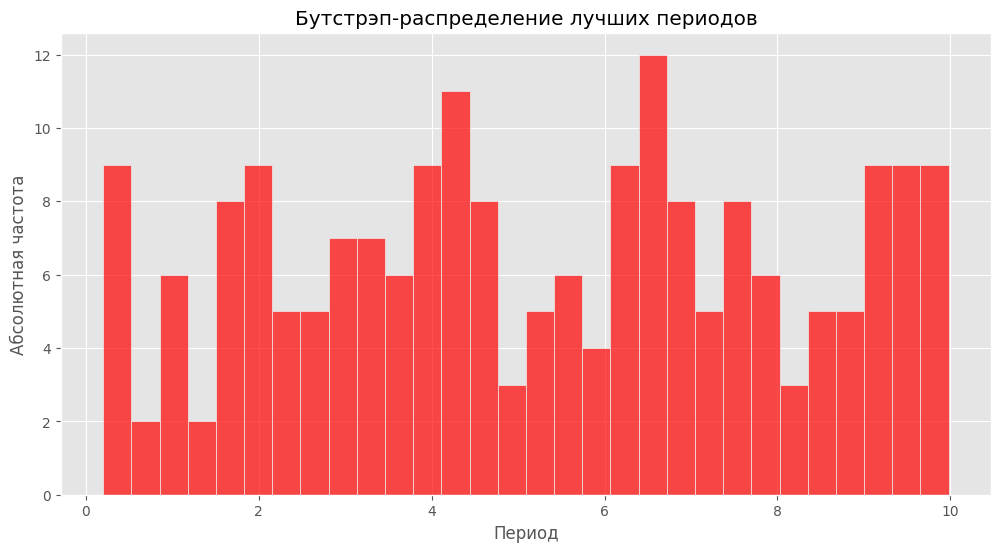

Доля реализаций в +/- 1% от P_best: 0.005
Доверительный интервал (16–84%): 2.065730 <= x <= 8.609045 дней


In [252]:
plt.figure(figsize=(12, 6))
sns.histplot(best_periods, bins=30, color='r', alpha=0.7)
plt.xlabel('Период')
plt.ylabel('Абсолютная частота')
plt.title('Бутстрэп-распределение лучших периодов')
plt.show()

P_best = best_period * 2

mask = (best_periods > 0.99 * P_best) & (best_periods < 1.01 * P_best)
fraction_in_1pct = np.sum(mask) / len(best_periods)
print(f'Доля реализаций в +/- 1% от P_best: {fraction_in_1pct:.3f}')

interval = np.percentile(best_periods, [16, 84])
print(f'Доверительный интервал (16–84%): {interval[0]:.6f} <= x <= {interval[1]:.6f} дней')

Наши предположения о $FAP$ согласуются с полученными метриками.

## **7 Классификация: простая эвристика по признакам формы**

Затменная система, если выполняются **все** условия:
  - $R_{21}>0,35$ (выраженная негармоничность, два затмения за цикл)

  - Асимметрия (доля фазы восхода) $<0,4$ (резкий, быстрый подъём, типичный для затменных)
Пульсирующая переменная — иначе.


In [253]:
R21 = np.sqrt(a1**2 + b1**2) / np.sqrt(a2**2 + b2**2) # RED21, я аж прослезился
df_clipped.loc[:, 'confidence'] = (R21 * (df['mag'] - df['mag'].min()))
df_clipped.sort_values('confidence', ascending=False).head(10)

,JD,mag,phase,confidence
94,2.454109e+06,16.52,0.061754,0.631545
84,2.454465e+06,16.51,0.055135,0.623936
325,2.455984e+06,16.50,0.992008,0.616327
277,2.455622e+06,16.49,0.979209,0.608718
355,2.456227e+06,16.49,0.971555,0.608718
198,2.455162e+06,16.49,0.984730,0.608718
123,2.454581e+06,16.49,0.066568,0.608718
294,2.455269e+06,16.48,0.986760,0.601109
327,2.456002e+06,16.48,0.045022,0.601109
30,2.453643e+06,16.48,0.004432,0.601109


Ограничения
 - Сложные случаи: Для звёзд с близкими значениями признаков правило может ошибаться, особенно для затменных с неравными минимумами или сложных пульсирующих форм.
  - Обогащение: Точность выше с добавлением меток, фазовых кривых высокой точности и дополнительных признаков (например, цвет, амплитуда на других фильтрах, shape тесты).


## **8 Репорт качества и воспроизводимости**

| $T_{span}$ | $Δ t_{med}$ | $\hat{P} $ | $FAP$ | $A$ | $\phi_{\max}/\phi_{\min}$ | $R_{21}$ | $\varphi_{21}$ | $2\hat{P}$ | бутстрэп-интервалы |
|-|-|-|-|-|-|-|-|-|-----|
| $3127.3$ | $0.007270$ | $1.483371$ | $\frac{1}{3}$ | $0,55$ |$0,166667$ | $0.760897$ | $ -2.2176890$ | $True$ | $(1.788252; 8.721622)$ |

- Фильтрация: одношаговый $3\sigma$-клинниг
- Сетка частот - по ТЗ (шаг - $0,1$)
- Порядок Фурье - $N=4$
- Параметры сглаживания - линейное интерполирование
- `random seed = 42`

In [254]:
import matplotlib as plt
import scipy as sps

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", plt.__version__)
print("astropy:", astropy.__version__)
print("scipy:", sps.__version__)

numpy: 2.0.2
pandas: 2.2.2
matplotlib: 3.10.0
astropy: 7.1.1
scipy: 1.16.3
